***Problem statement:***
- To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data , take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import glob

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


***NOTE:***

- You don't have to use any pre-trained model using Transfer learning. All the model building processes should be based on a custom model.
- Some of the elements introduced in the assignment are new, but proper steps have been taken to ensure smooth learning. You must learn from the base code provided and implement the same for your problem statement.
- The model training may take time to train as you will be working with large epochs. It is advised to use GPU runtime in Google Colab.

- This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing, Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset ,Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

## Write your train dataset here
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# Using class_names attribute. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

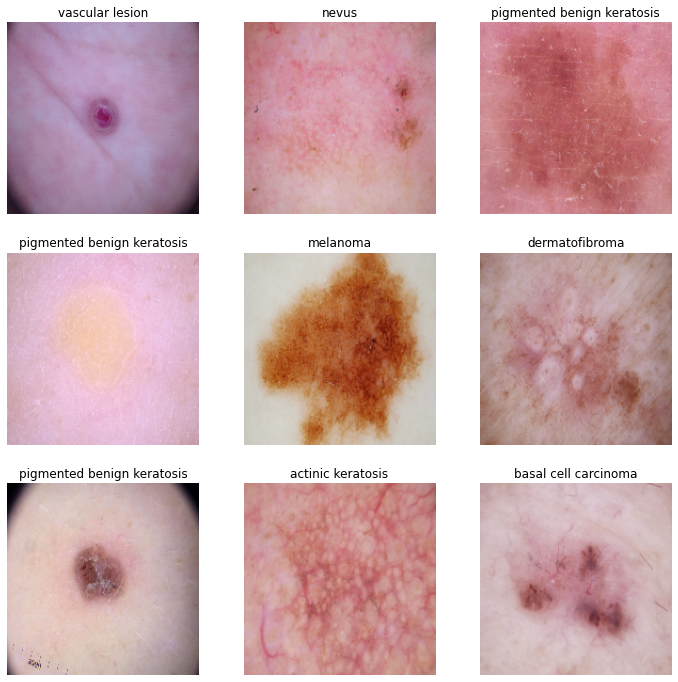

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

**MODEL 1**

In [11]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [12]:
num_classes = 9
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

### Compile the model
- Choose an appropirate optimiser and loss function for model training 

In [13]:
# compile the model
model.compile(optimizer='adamax',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [14]:
# train 
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 19s 95ms/step - loss: 2.0271 - accuracy: 0.2316 - val_loss: 1.9603 - val_accuracy: 0.2774
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 1.8075 - accuracy: 0.3571 - val_loss: 1.6682 - val_accuracy: 0.3893
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6245 - accuracy: 0.4219 - val_loss: 1.6069 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5817 - accuracy: 0.4330 - val_loss: 1.6912 - val_accuracy: 0.3982
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4801 - accuracy: 0.4849 - val_loss: 1.5687 - val_accuracy: 0.4452
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3781 - accuracy: 0.5089 - val_loss: 1.4125 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3348 - accuracy: 0.5340 - val_loss: 1.4133 - val_accuracy: 0.5391
Epoch 8/20
56/56 [=====

### Visualizing training results

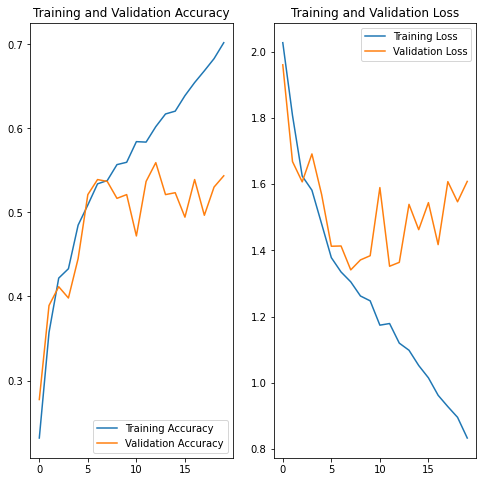

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

**Observation**: From the above model we can clearly see that our model is getting overfitted and huge gap between train accuracy and validation accuracy

**So, We will use the layer data augumentation strategy to try to overcome this overfittiing**

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.3,fill_mode="reflect"),
  layers.experimental.preprocessing.RandomZoom(.5, .2)
])

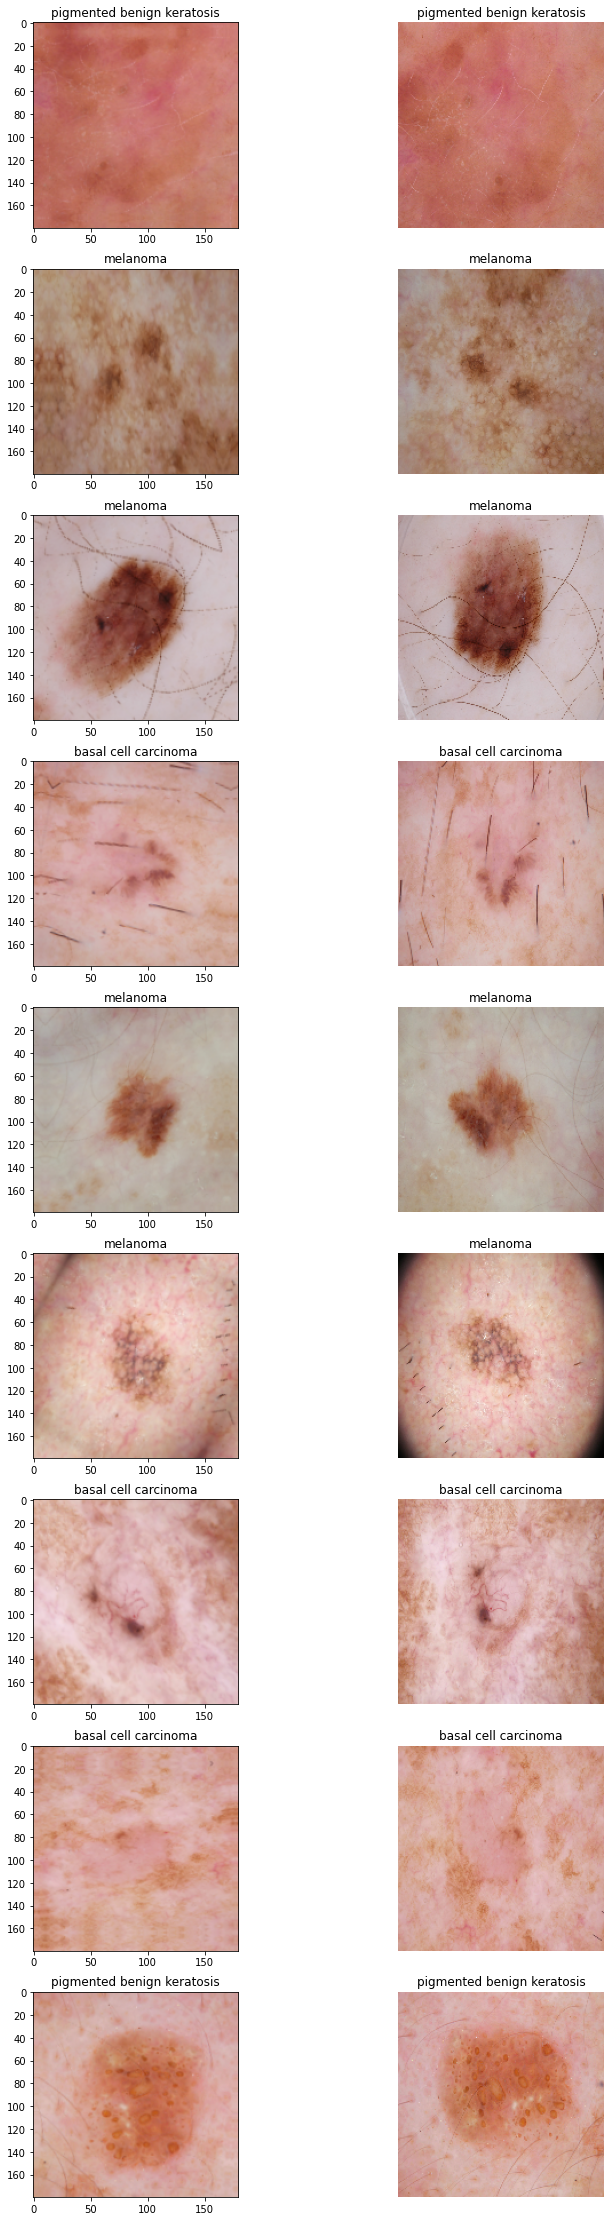

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 40))
for images, labels in list(train_ds.take(1)):
  augmented_image = data_augmentation(images)
  j=1
  for i in range(9):
    ax = plt.subplot(9, 2, j)
    plt.imshow(augmented_image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    j+=1

    ax = plt.subplot(9, 2, j)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    j+=1

  plt.show()

### Todo:
### Create the model, compile and train the model , after data augumentation.


**MODEL 2**

In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
data_augmentation
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adamax',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        9248      
                                                      

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 3s 48ms/step - loss: 2.0688 - accuracy: 0.1892 - val_loss: 2.1184 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 3s 45ms/step - loss: 2.0391 - accuracy: 0.1942 - val_loss: 2.0643 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 2s 44ms/step - loss: 2.0353 - accuracy: 0.1970 - val_loss: 2.0508 - val_accuracy: 0.2304
Epoch 4/20
56/56 [==============================] - 2s 44ms/step - loss: 1.9650 - accuracy: 0.2684 - val_loss: 1.9108 - val_accuracy: 0.3244
Epoch 5/20
56/56 [==============================] - 2s 44ms/step - loss: 1.7894 - accuracy: 0.3583 - val_loss: 1.7554 - val_accuracy: 0.3579
Epoch 6/20
56/56 [==============================] - 2s 44ms/step - loss: 1.7030 - accuracy: 0.3744 - val_loss: 1.6907 - val_accuracy: 0.4452
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 1.6756 - accuracy: 0.4012 - val_loss: 1.8631 - val_accuracy: 0.3221
Epoch 8/20
56/56 [======

### Visualizing the results

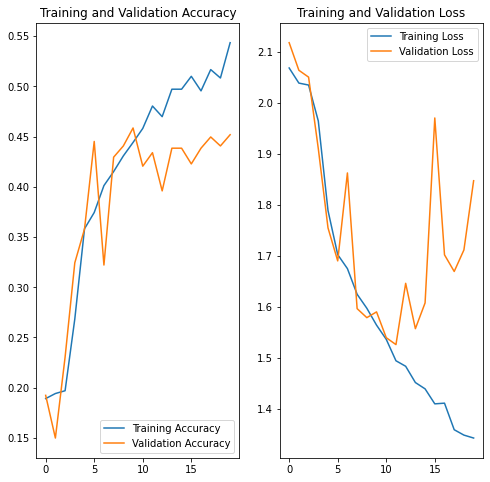

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Observation after doing data augumentation:-**
- Training accuracy decreases from 70.2% to 54.35%
- The training and validation accuracy gap has been greatly reduced.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## Your code goes here.
df  = []
for i in class_names:
  path_list = [x for x in data_dir_train.glob(i+'/*.jpg')]
  df.append(len(path_list))
df = pd.DataFrame(list(zip(class_names,df)),columns=["class","counts"])
print(df)


                        class  counts
0           actinic keratosis     114
1        basal cell carcinoma     376
2              dermatofibroma      95
3                    melanoma     438
4                       nevus     357
5  pigmented benign keratosis     462
6        seborrheic keratosis      77
7     squamous cell carcinoma     181
8             vascular lesion     139


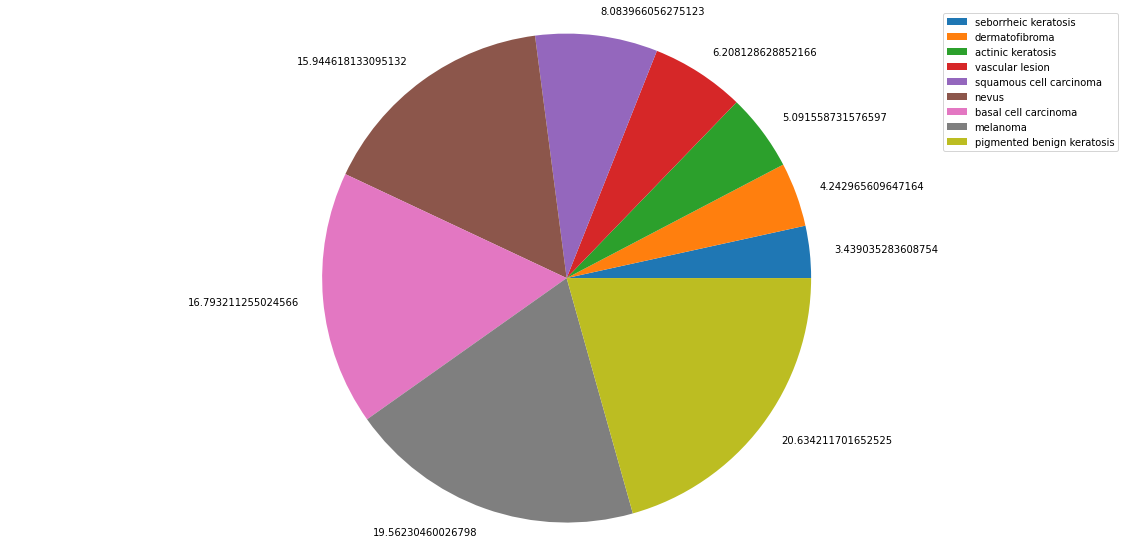

In [23]:
df['counts'] = (df['counts']/sum(df.counts))*100
df.sort_values(by="counts",inplace=True)
plt.figure(figsize=(20,10))
plt.pie( df["counts"],labels=df["counts"])
plt.legend(df["class"], loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

#### - Which class has the least number of samples?
- ***seborrheic keratosis*** has the least number of samples.

#### - Which classes dominate the data in terms proportionate number of samples?
- ***nevus, basal cell carcinoma, melanoma and pigmented benign keratosis*** dominates the data in terms of proportionate number of sample.


In [24]:
path_list = [x for x in data_dir_train.glob(os.path.join( '*', '*.jpg'))]
print("path_list: ",len(path_list))
lesion_list = [os.path.basename(os.path.dirname(y)) for y in data_dir_train.glob(os.path.join( '*', '*.jpg'))]
print("lesion_list: ",len(lesion_list))
dataframe_dict = dict(zip(path_list, lesion_list))

path_list:  2239
lesion_list:  2239


#### To Rectify the class imbalance, You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

#### To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset= "/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/"

import Augmentor as aug
for i in class_names:
    p = aug.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0708C39610>: 100%|██████████| 500/500 [00:19<00:00, 25.46 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0708D53A50>: 100%|██████████| 500/500 [00:21<00:00, 23.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0708F9C110>: 100%|██████████| 500/500 [00:21<00:00, 23.68 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2313x1985 at 0x7F0708D5C3D0>: 100%|██████████| 500/500 [01:34<00:00,  5.29 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0708D20F90>: 100%|██████████| 500/500 [01:29<00:00,  5.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F079C124450>: 100%|██████████| 500/500 [00:18<00:00, 27.01 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F0708C52AD0>: 100%|██████████| 500/500 [00:41<00:00, 12.06 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F081EBBA890>: 100%|██████████| 500/500 [00:18<00:00, 27.75 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F079C247090>: 100%|██████████| 500/500 [00:18<00:00, 27.18 Samples/s]


#### Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list = [x for x in data_dir_train.glob(os.path.join( '*','output', '*.jpg'))]
path_list[:10]

[PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/output/melanoma_original_ISIC_0011138.jpg_2fa059e8-c8e8-46b6-8bf4-34a2b38fbceb.jpg'),
 PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/output/melanoma_original_ISIC_0000280.jpg_e62f5491-33a7-4b79-ae1b-673f0d31e762.jpg'),
 PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/output/melanoma_original_ISIC_0010591.jpg_3ec5f412-d4b8-4fb9-ace4-82244d68d611.jpg'),
 PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/output/melanoma_original_ISIC_0010271.jpg_ca60cf41-4164-4de0-ba74-a1fff0b9e6bd.jpg'),
 PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/output/melanoma_original_ISIC_0010379.jpg_b4a6bc58-7168-4180-8eec-49711f145807.jpg'),
 PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/output/melanoma_original_ISIC_0009934.jpg_3573a4e0-c87b-4370-88ee-bcd91a11d99a.jpg'),
 PosixPath('/content/gdrive/MyDriv

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob(os.path.join( '*','output', '*.jpg'))]
lesion_list_new[:10]

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma']

In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
list(dataframe_dict.items())[:10]

[(PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/ISIC_0000144.jpg'),
  'melanoma'),
 (PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/ISIC_0000139.jpg'),
  'melanoma'),
 (PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/ISIC_0000143.jpg'),
  'melanoma'),
 (PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/ISIC_0000142.jpg'),
  'melanoma'),
 (PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/ISIC_0000141.jpg'),
  'melanoma'),
 (PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/ISIC_0000176.jpg'),
  'melanoma'),
 (PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/ISIC_0000291.jpg'),
  'melanoma'),
 (PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/ISIC_0000164.jpg'),
  'melanoma'),
 (PosixPath('/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/melanoma/ISIC_0000159.jpg'),
  'melanoma'),
 

In [32]:
dataframe_dict = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
dataframe_dict
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = dataframe_dict.append(df2)

In [33]:
new_df.Label.count()

6739

## So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training, validation datasets on whole image data

In [35]:
data_dir_train= "/content/gdrive/MyDrive/Assignments/MelanomaCNN/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model

**MODEL 3**

In [37]:
## your code goes here
num_classes = 9
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

#### Compile your model (Choose optimizer and loss function appropriately)

In [38]:
## your code goes here
model.compile(optimizer='adamax',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        9248      
                                                      

####   Train your model

In [39]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 33s 184ms/step - loss: 2.0145 - accuracy: 0.2177 - val_loss: 1.8243 - val_accuracy: 0.2814
Epoch 2/30
169/169 [==============================] - 31s 179ms/step - loss: 1.7691 - accuracy: 0.3014 - val_loss: 1.6995 - val_accuracy: 0.3326
Epoch 3/30
169/169 [==============================] - 31s 176ms/step - loss: 1.6575 - accuracy: 0.3540 - val_loss: 1.5440 - val_accuracy: 0.4336
Epoch 4/30
169/169 [==============================] - 31s 175ms/step - loss: 1.5127 - accuracy: 0.4139 - val_loss: 1.4381 - val_accuracy: 0.4380
Epoch 5/30
169/169 [==============================] - 31s 176ms/step - loss: 1.4331 - accuracy: 0.4401 - val_loss: 1.3234 - val_accuracy: 0.4855
Epoch 6/30
169/169 [==============================] - 31s 176ms/step - loss: 1.3664 - accuracy: 0.4707 - val_loss: 1.3848 - val_accuracy: 0.4625
Epoch 7/30
169/169 [==============================] - 31s 176ms/step - loss: 1.2970 - accuracy: 0.5002 - val_loss: 1.2528 - val_accuracy: 0.5

####  Visualize the model results

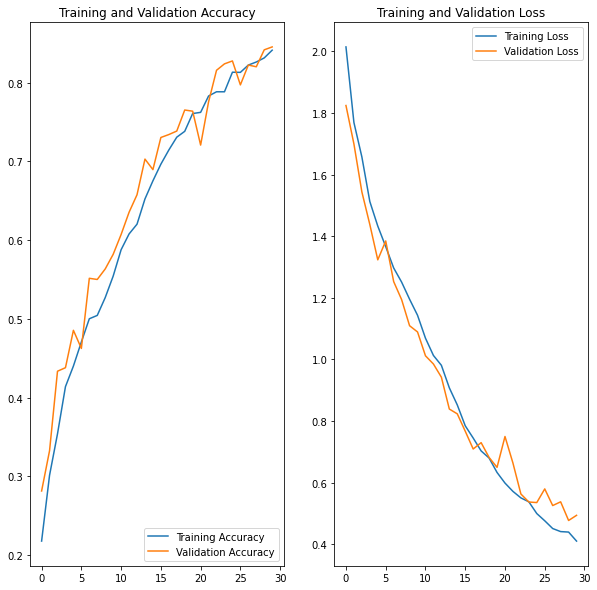

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

***Q1:  Did we get rid of the overfitting?***
- Yes, after adding **dropouts, augomentation(rebalance)**, we see significant raise in accuracies and least gap between tran and val Accuracies

***Q2: Did class rebalance help?***
- Yes, rebalancing greatly helped in increasing the model accuracy.

**MODEL DEATILS**

**Model 1: Basic model**

Accuracy: 70.2%

Val. Accuracy: 54.36%


---
**Model 2: Basic model + dropouts**

Accuracy: 54.39%

Val. Accuracy: around 45.19%

---
**Model 3: Basic model + dropouts + rebalancing**

Accuracy: 84.14%

Val. Accuracy: 84.56%

***Result***
- So, according to my analysis **MODEL 3 (Basic model + dropouts + rebalancing)** is a good model. And I will select with model 3 because the difference between training and validation set is less and accuracy is acceptable.
- For evaluation purpose , please make usage of ***model 3 on test data*** set given below

In [45]:
## Write your test dataset here
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
